# Youtube Trending Video Analysis

The dataset used on this jupyter notebook analysis can be downloaded on Kaggle: [https://www.kaggle.com/datasets/rsrishav/youtube-trending-video-dataset](https://www.kaggle.com/datasets/rsrishav/youtube-trending-video-dataset). 

**Author:** BrenoAV

**Last Date Modified:** 11/20/2023

In [1]:
from collections import defaultdict
from itertools import chain
import json
import logging
import os
import sys
import pprint
from dataclasses import dataclass
from datetime import datetime
import warnings
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import yaml
import requests
import pyspark
from pyspark.sql import SparkSession, Window
from pyspark.sql import functions as F
from pyspark.sql.types import StringType, IntegerType, BooleanType, ArrayType
from pyspark.ml.stat import Correlation
from pyspark.ml.feature import VectorAssembler
from src.helpers import get_channel_title_by_id, get_map_category_name_by_id, title_tokenize

In [27]:
def print_last_year(date_complete: str) -> None:
    print(f"The last year is {date_complete.split('-')[0]}")

In [2]:
matplotlib.style.use("seaborn-v0_8-whitegrid")
warnings.filterwarnings( "ignore", module = "IPython\..*" )

In [3]:
logging.basicConfig(level=logging.ERROR)

# Config

In [4]:
@dataclass
class Config:
    country: str
    num_of_videos_limit: int

    @classmethod
    def from_yaml(cls, yaml_file: str):
        logging.info("Loading config file %s", yaml_file)
        with open(yaml_file, "r", encoding="utf-8") as config_file:
            config = yaml.safe_load(config_file)

        assert isinstance(config["country"], str), "country is not a string type"
        assert config["country"].upper() in ["BR", "CA", "DE", "FR", "GB", "IN", "JP", "KR", "MX", "RU", "US"],\
                "not a valid option: 'BR', 'CA', 'DE', 'FR', 'GB', 'IN', 'JP', 'KR', 'MX', 'RU', 'US'"
        assert isinstance(config["num_of_videos_limit"], int), "num_of_videos_limit is not an int"
        return cls(country=config["country"].upper(),
                   num_of_videos_limit=config["num_of_videos_limit"])
config = Config.from_yaml("config.yml")
print(config)

Config(country='BR', num_of_videos_limit=30)


# Load dataset

I'm using the Kaggle API to download the dataset directly, you can find more details how to set up here: [https://github.com/Kaggle/kaggle-api](https://github.com/Kaggle/kaggle-api)

In [6]:
# You need to have YOUR CREDENTIALS set up
!kaggle datasets download --force -d rsrishav/youtube-trending-video-dataset

In [7]:
# Just uncompressing the zip file in a folder
!mkdir youtube-trending-video-dataset
!unzip -o youtube-trending-video-dataset.zip -d youtube-trending-video-dataset

In [5]:
spark = SparkSession \
    .builder \
    .appName("Youtube Trending Video Analysis") \
    .getOrCreate()

23/11/20 21:45:34 WARN Utils: Your hostname, debian resolves to a loopback address: 127.0.1.1; using 10.0.0.183 instead (on interface eno1)
23/11/20 21:45:34 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
23/11/20 21:45:34 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [78]:
spark

In [6]:
df = spark.read.csv(f"youtube-trending-video-dataset/{config.country}_youtube_trending_data.csv", 
                    sep=",",
                    inferSchema=True, 
                    header=True, 
                    lineSep="\n")

In [7]:
df.show(5)

+-----------+--------------------+-------------------+--------------------+--------------------+----------+-------------------+--------------------+----------+------+--------+-------------+--------------------+-----------------+----------------+--------------------+
|   video_id|               title|        publishedAt|           channelId|        channelTitle|categoryId|      trending_date|                tags|view_count| likes|dislikes|comment_count|      thumbnail_link|comments_disabled|ratings_disabled|       description\r|
+-----------+--------------------+-------------------+--------------------+--------------------+----------+-------------------+--------------------+----------+------+--------+-------------+--------------------+-----------------+----------------+--------------------+
|s9FH4rDMvds|LEVEI UM FORA? FI...|2020-08-11 19:21:49|UCGfBwrCoi9ZJjKiU...|       Pietro Guedes|        22|2020-08-11 21:00:00|pietro|guedes|ing...|    263835| 85095|     487|         4500|https://i.

In [8]:
df = df.withColumnRenamed("description\r", "description")

In [9]:
df = df.drop(*["thumbnail_link"])

In [10]:
# Transforming the comment_count (manually) in int because probably have some invalid int values
df = df.withColumn("comment_count", F.col("comment_count").cast(IntegerType()))
df = df.withColumn("ratings_disabled", F.col("ratings_disabled").cast(BooleanType()))

In [11]:
df.printSchema()

root
 |-- video_id: string (nullable = true)
 |-- title: string (nullable = true)
 |-- publishedAt: timestamp (nullable = true)
 |-- channelId: string (nullable = true)
 |-- channelTitle: string (nullable = true)
 |-- categoryId: integer (nullable = true)
 |-- trending_date: timestamp (nullable = true)
 |-- tags: string (nullable = true)
 |-- view_count: integer (nullable = true)
 |-- likes: integer (nullable = true)
 |-- dislikes: integer (nullable = true)
 |-- comment_count: integer (nullable = true)
 |-- comments_disabled: boolean (nullable = true)
 |-- ratings_disabled: boolean (nullable = true)
 |-- description: string (nullable = true)



# Create a mapping dataframe 

In [12]:
map_id_title = df.select(["channelId", "channelTitle"]).distinct()

In [13]:
map_id_title.show(5, truncate=False)

+------------------------+------------------------+
|channelId               |channelTitle            |
+------------------------+------------------------+
|UCxcJlObi1B4hKPY-so-4myw|Edi Rock                |
|UCCoDqrBGLRIM8Ih8RApfk2A|EMI                     |
|UC7fCYSfauoMDbdBZ9B0ex2Q|Konai                   |
|UCWuihCjrujsgRZ4ohWidZWw|Irmãos a obra Araraquara|
|UCxc3marqP9BJSkQ0_K4mqDg|Arena SBT               |
+------------------------+------------------------+
only showing top 5 rows



In [14]:
# Example how we can use
example_title = get_channel_title_by_id(channel_id="UC_Fk7hHbl7vv_7K8tYqJd5A", 
                                map_id_title=map_id_title)
print(f"Example of get_channel_info_by_id: {example_title}")

Example of get_channel_info_by_id: SpaceToday


# Exploratory Data Analysis

## Checking the missing values

In [15]:
df_isnan = df.select([F.count(F.when(F.isnan(col_n) | F.isnull(col_n), col_n)).alias(col_n) 
                   if col_t not in ("boolean", "timestamp", "date") 
                   else F.count(F.when(F.isnull(col_n), col_n)).alias(col_n) 
                   for col_n, col_t in df.dtypes
                   ])
df_isnan.toPandas().T

,0
video_id,0
title,0
publishedAt,0
channelId,0
channelTitle,0
categoryId,0
trending_date,0
tags,0
view_count,0
likes,0


In [16]:
# Removing the video with comment_count problem
df = df.filter(~F.col("comment_count").isNull())

In [17]:
df_isnan = df.select([F.count(F.when(F.isnan(col_n) | F.isnull(col_n), col_n)).alias(col_n) 
                   if col_t not in ("boolean", "timestamp", "date") 
                   else F.count(F.when(F.isnull(col_n), col_n)).alias(col_n) 
                   for col_n, col_t in df.dtypes
                   ])
df_isnan.toPandas().T

,0
video_id,0
title,0
publishedAt,0
channelId,0
channelTitle,0
categoryId,0
trending_date,0
tags,0
view_count,0
likes,0


In [18]:
total_videos = df.count()
unique_channels = df.select("channelId").distinct().count()
print(f"Number of videos on trending: {df.count()}")
print(f"How many channels reach the trending: {unique_channels}, which means {unique_channels/total_videos * 100:.2f}% of the total videos")

Number of videos on trending: 239382
How many channels reach the trending: 5309, which means 2.22% of the total videos


From the total of videos, belongs an only 5304 channels that dominate the YouTube Trending which is equivalent to 2.22% of the total videos

## Channels that spent more time with videos on trending by year

In [21]:
years = [f"{year[0]}-01-01" for year in df.withColumn("year", F.year(F.col("publishedAt")))\
                                          .select("year").distinct().orderBy(F.col("year")).collect()]

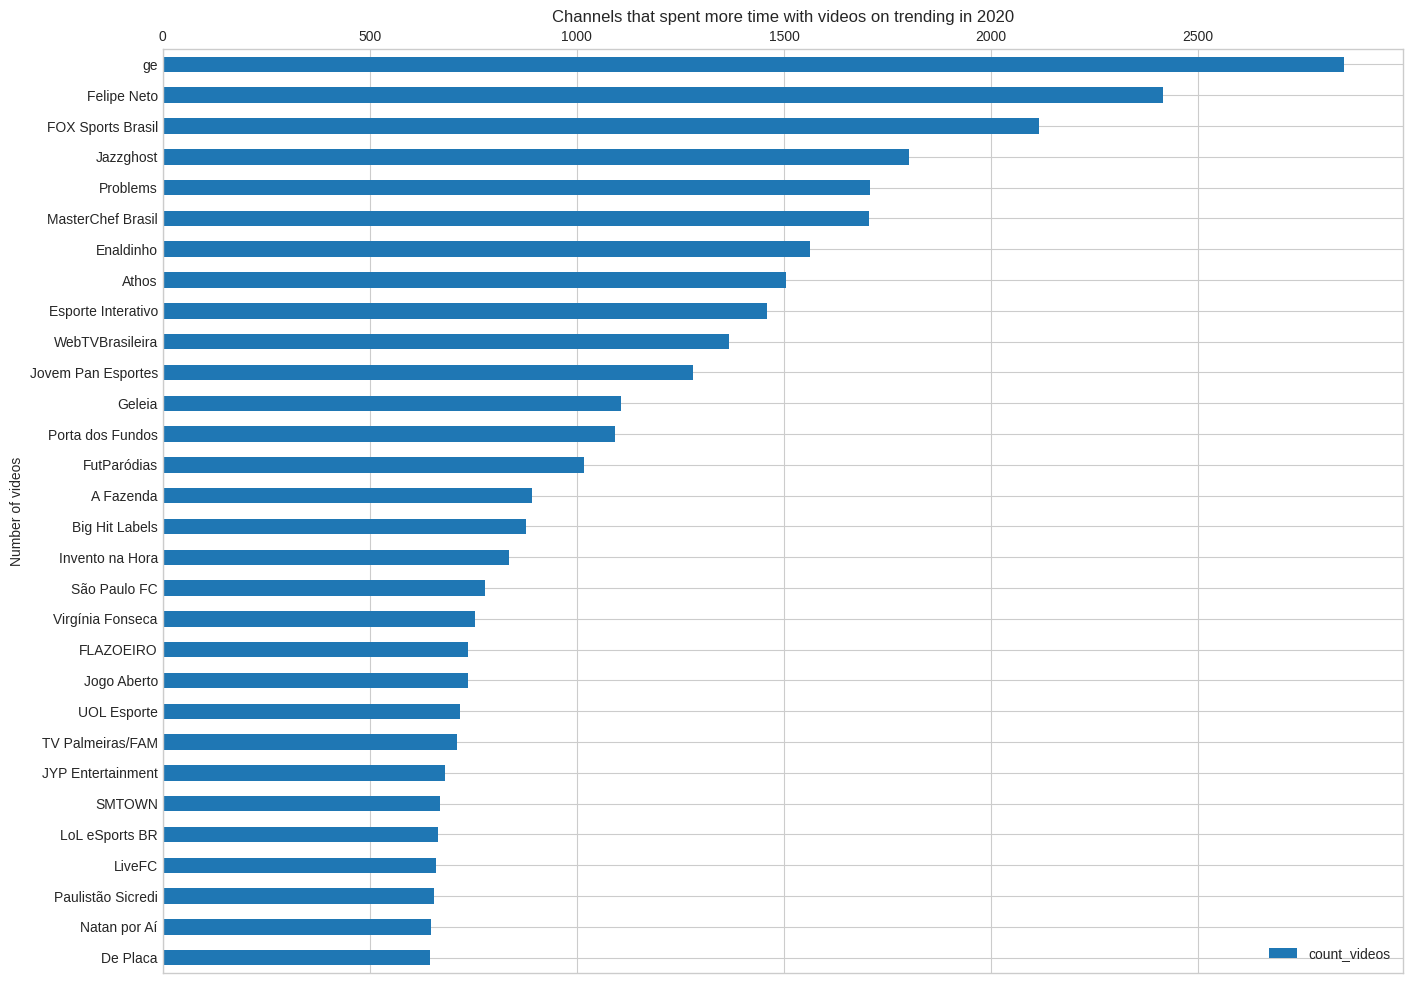

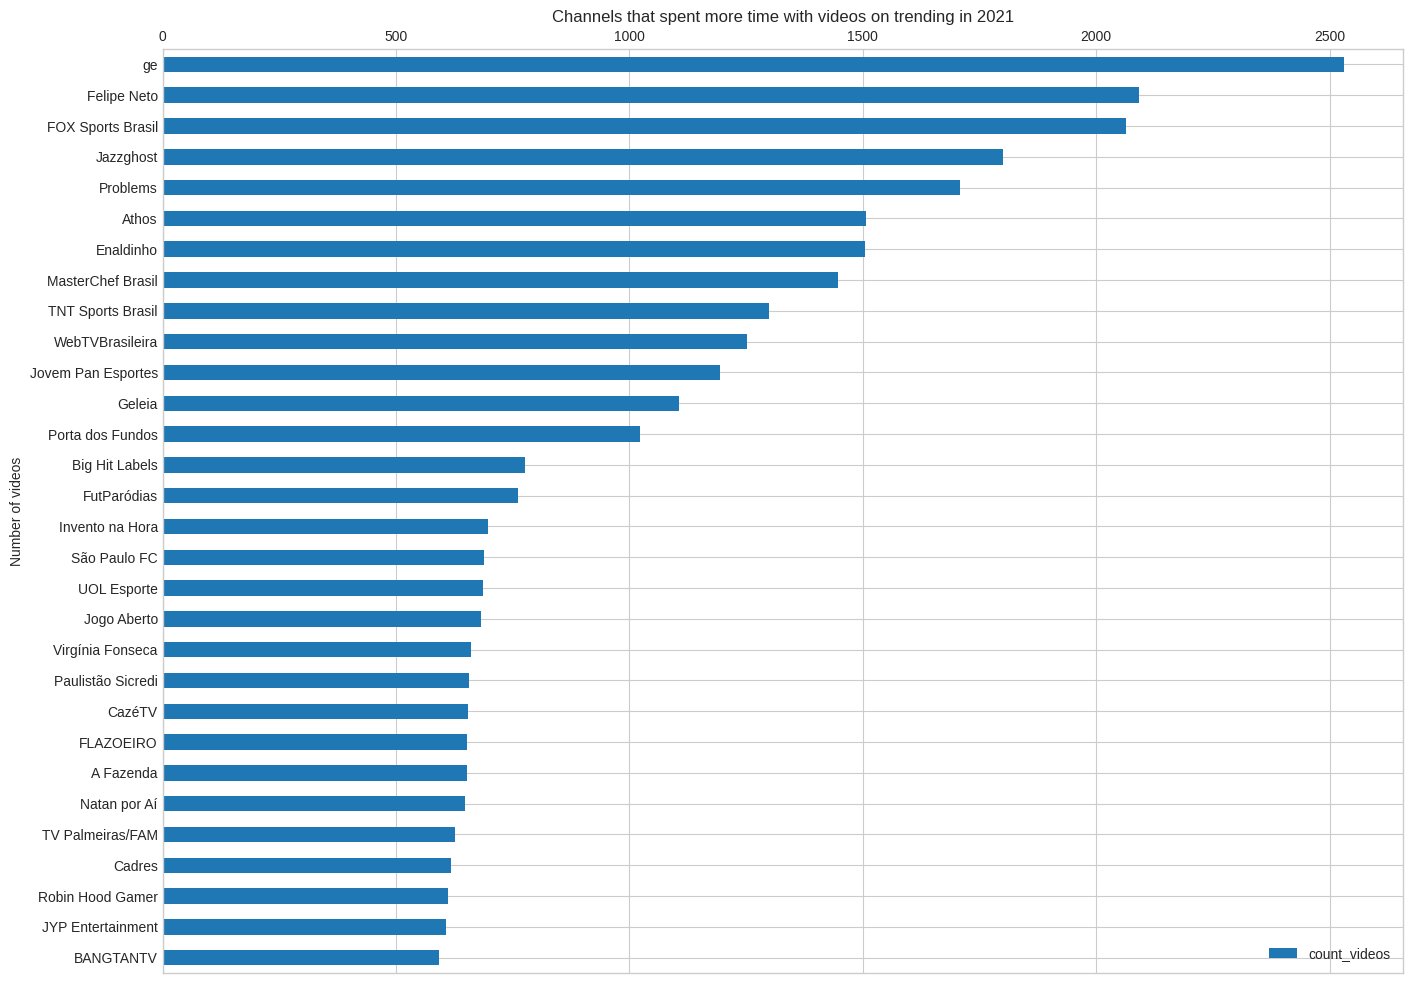

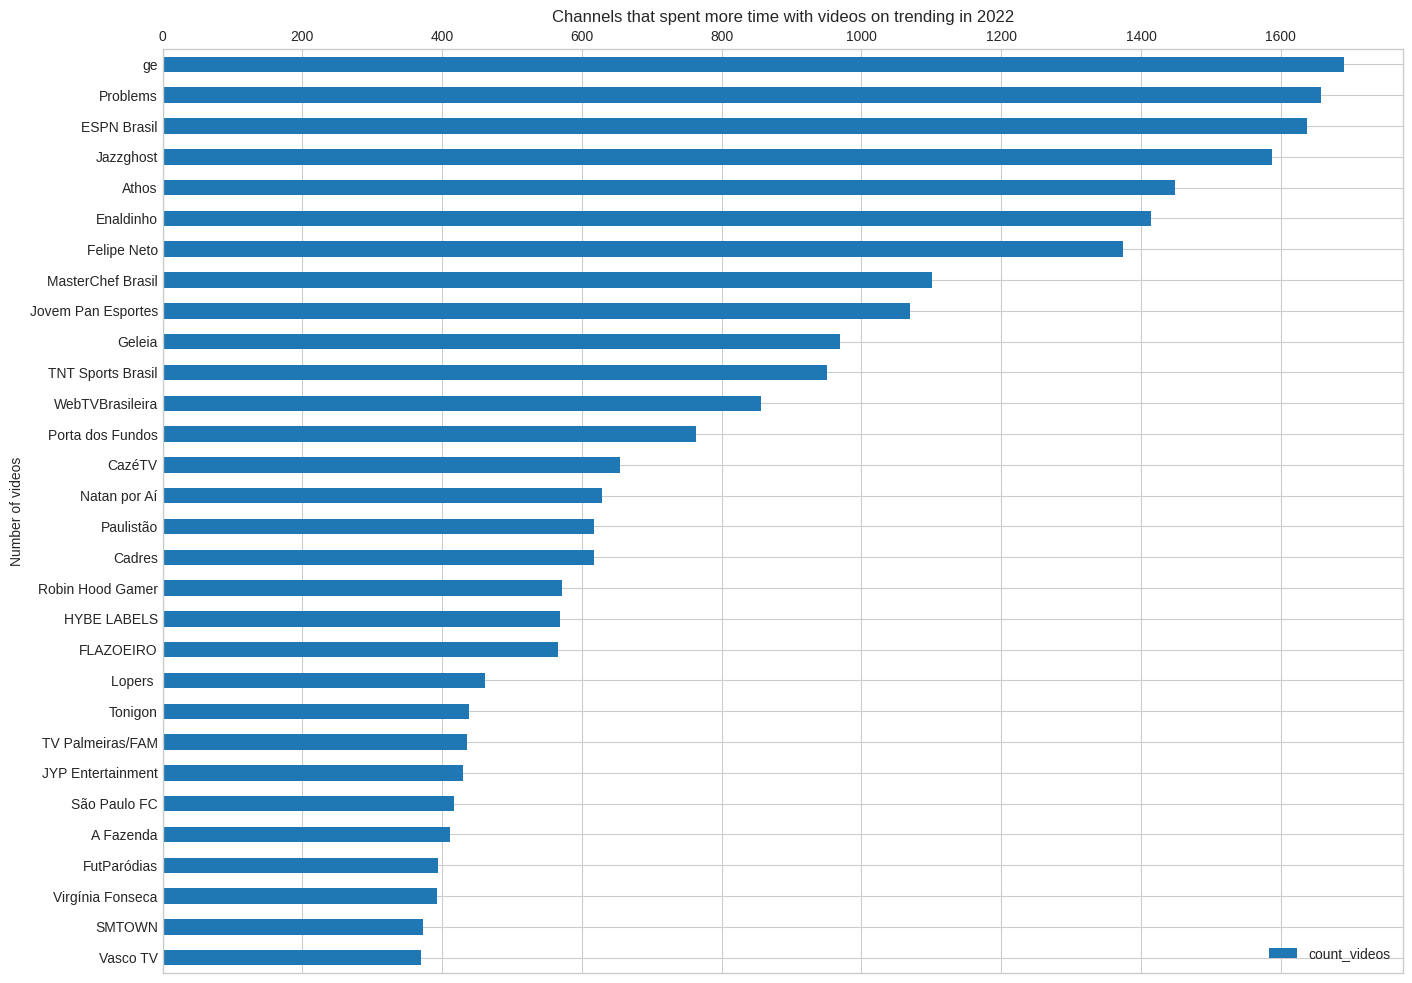

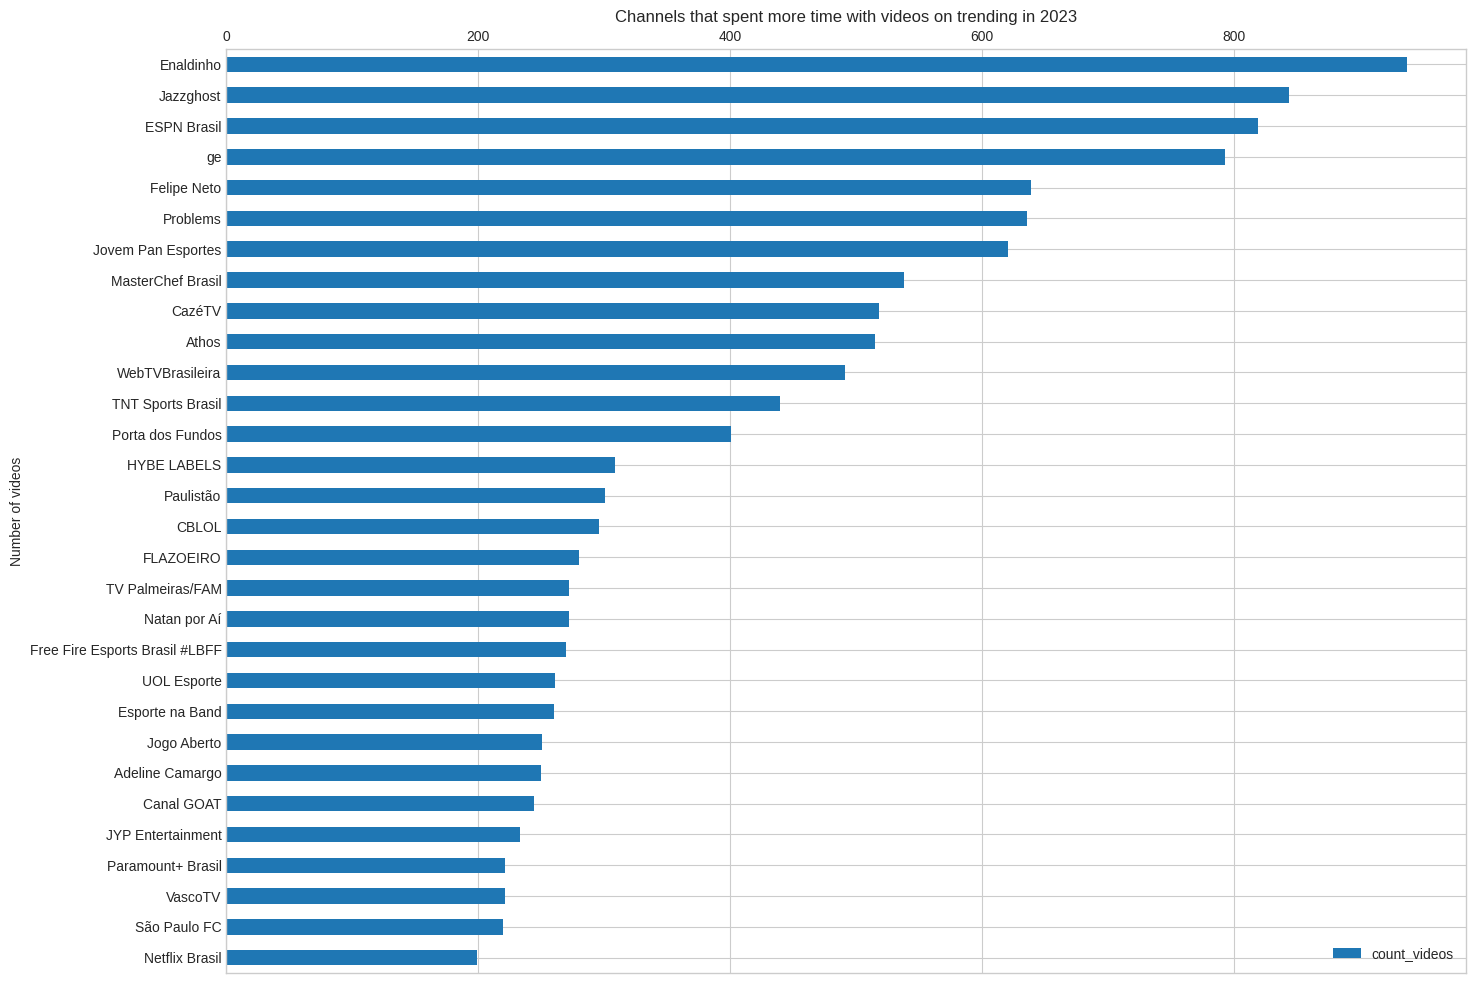

In [22]:
for date in years:
    df_this_year = df.filter(df["publishedAt"]>=date)
    window_spec = Window.partitionBy("channelId")
    df_count = df_this_year.withColumn("count_videos", F.count("channelId").over(window_spec))
    df_count = df_count.select(["channelId", "channelTitle", "count_videos"])\
                       .dropDuplicates(["channelId"])\
                       .orderBy(F.desc("count_videos"))\
                       .limit(config.num_of_videos_limit)
    ax = df_count.toPandas().iloc[::-1].plot.barh(x="channelTitle", 
                                             y="count_videos", 
                                             ylabel="Number of videos",
                                             title=(f"Channels that spent more time with videos "
                                                    f"on trending in {date.split('-')[0]}"), figsize=(16, 12))
    ax.xaxis.tick_top()
    plt.show()

## Categories 

In [23]:
df_categories = df.groupby("categoryId").count()
df_categories.show()

+----------+-----+
|categoryId|count|
+----------+-----+
|        28| 3181|
|        27| 2928|
|        26| 1828|
|        22|29741|
|         1| 2723|
|        20|35179|
|        19| 1103|
|        15|  297|
|        17|35115|
|        23| 9683|
|        10|53090|
|        25| 3868|
|        24|58334|
|         2| 2244|
|        29|   68|
+----------+-----+



+----------+-----+--------------------+
|categoryId|count|       category_name|
+----------+-----+--------------------+
|        24|58334|       Entertainment|
|        10|53090|               Music|
|        20|35179|              Gaming|
|        17|35115|              Sports|
|        22|29741|      People & Blogs|
|        23| 9683|              Comedy|
|        25| 3868|     News & Politics|
|        28| 3181|Science & Technology|
|        27| 2928|           Education|
|         1| 2723|    Film & Animation|
|         2| 2244|    Autos & Vehicles|
|        26| 1828|       Howto & Style|
|        19| 1103|     Travel & Events|
|        15|  297|      Pets & Animals|
|        29|   68|                NULL|
+----------+-----+--------------------+



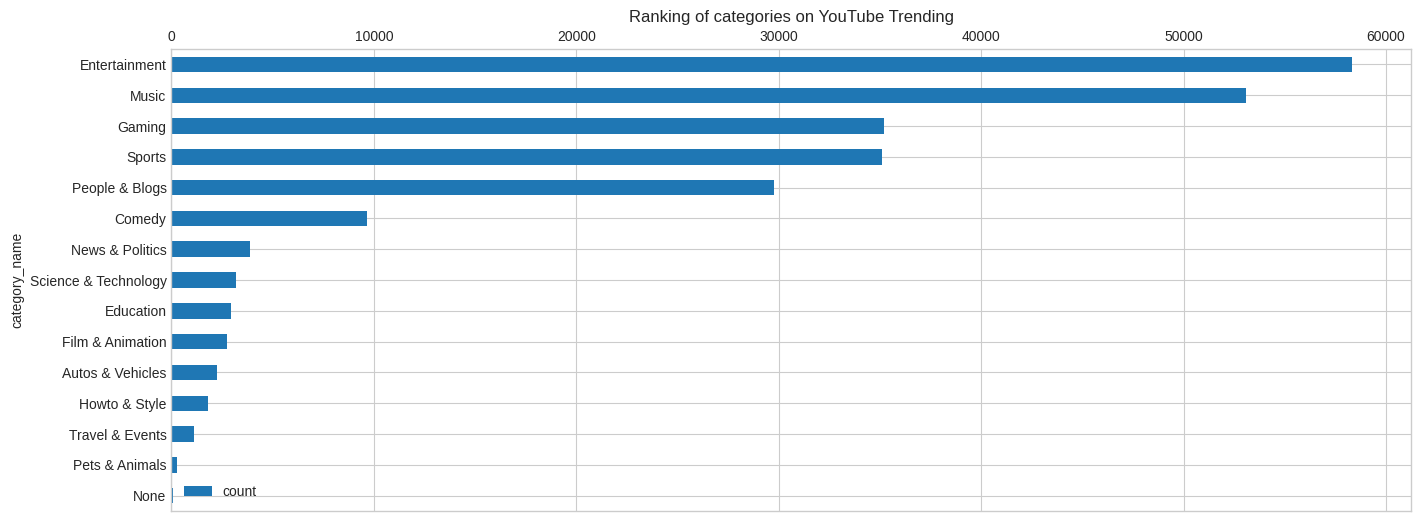

In [24]:
map_category_name_id = get_map_category_name_by_id(f"youtube-trending-video-dataset/{config.country}_category_id.json")
mapping_expr = F.create_map([F.lit(x) for x in chain(*map_category_name_id.items())])
df_categories = df_categories.withColumn("category_name", mapping_expr[F.col("categoryId")])
df_categories = df_categories.orderBy(F.desc("count"))
df_categories.show()
ax = df_categories.toPandas().iloc[::-1].plot.barh(x="category_name",
                                              y="count",
                                              title=f"Ranking of categories on YouTube Trending",
                                              figsize=(16, 6))
ax.xaxis.tick_top()

### Last Year

The last year is 2023
+----------+-----+--------------------+
|categoryId|count|       category_name|
+----------+-----+--------------------+
|        24|13803|       Entertainment|
|        10|12745|               Music|
|        20|11821|              Gaming|
|        17|11438|              Sports|
|        22| 6418|      People & Blogs|
|        23| 1536|              Comedy|
|        25| 1151|     News & Politics|
|        28|  974|Science & Technology|
|         1|  846|    Film & Animation|
|         2|  791|    Autos & Vehicles|
|        27|  607|           Education|
|        26|  545|       Howto & Style|
|        19|  383|     Travel & Events|
|        15|   28|      Pets & Animals|
|        29|    8|                NULL|
+----------+-----+--------------------+



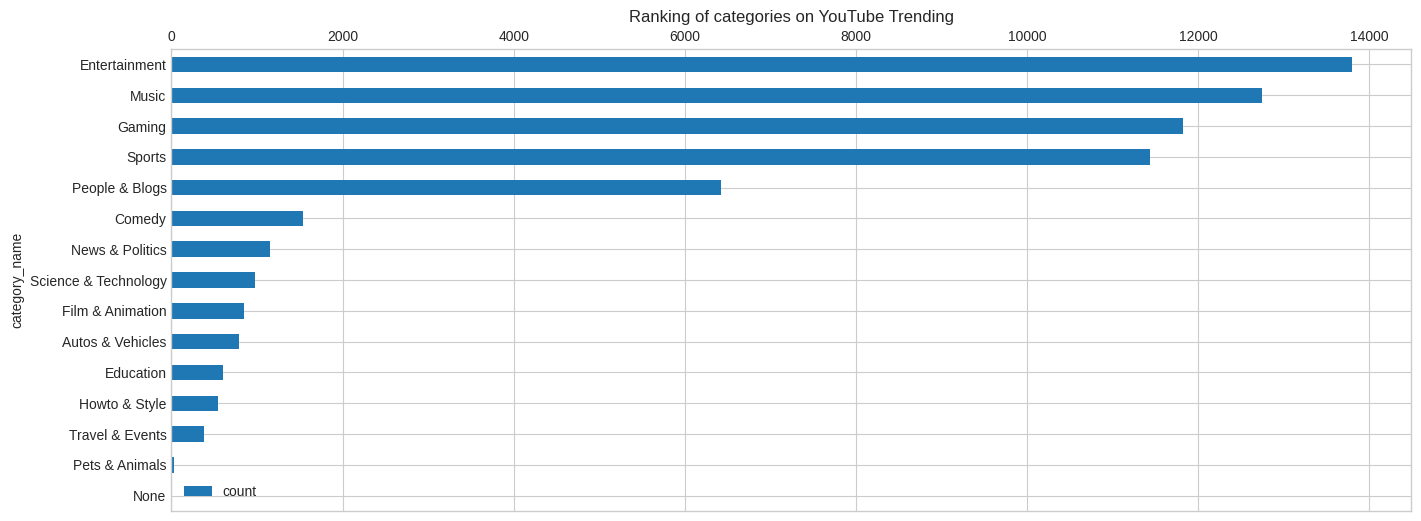

In [30]:
print_last_year(years[-1])
df_categories = df.filter(F.col("publishedAt") >= F.lit(years[-1])).groupby("categoryId").count()
map_category_name_id = get_map_category_name_by_id(f"youtube-trending-video-dataset/{config.country}_category_id.json")
mapping_expr = F.create_map([F.lit(x) for x in chain(*map_category_name_id.items())])
df_categories = df_categories.withColumn("category_name", mapping_expr[F.col("categoryId")])
df_categories = df_categories.orderBy(F.desc("count"))
df_categories.show()
ax = df_categories.toPandas().iloc[::-1].plot.barh(x="category_name",
                                              y="count",
                                              title=f"Ranking of categories on YouTube Trending",
                                              figsize=(16, 6))
ax.xaxis.tick_top()

**Analysis:** Basically the same category on the top (Entertainment)

## Channels with videos more views, likes and dislikes on the trending

In [31]:
# The dataset obtain the videos that are on trending. If the video is two days on the trending will have two records of the same video
# You can check more info here: https://www.kaggle.com/datasets/rsrishav/youtube-trending-video-dataset/discussion/212078
# This operation below will get only one video and the last one because is the video with more views (the views don't comeback)
df_unique = df.withColumn("max_view_count", F.max("view_count")\
              .over(Window.partitionBy("video_id")))\
              .where(F.col("view_count") == F.col("max_view_count"))

In [32]:
df_unique.printSchema()

root
 |-- video_id: string (nullable = true)
 |-- title: string (nullable = true)
 |-- publishedAt: timestamp (nullable = true)
 |-- channelId: string (nullable = true)
 |-- channelTitle: string (nullable = true)
 |-- categoryId: integer (nullable = true)
 |-- trending_date: timestamp (nullable = true)
 |-- tags: string (nullable = true)
 |-- view_count: integer (nullable = true)
 |-- likes: integer (nullable = true)
 |-- dislikes: integer (nullable = true)
 |-- comment_count: integer (nullable = true)
 |-- comments_disabled: boolean (nullable = true)
 |-- ratings_disabled: boolean (nullable = true)
 |-- description: string (nullable = true)
 |-- max_view_count: integer (nullable = true)



### views

+--------------+-----------+---------------------------------------+----------+
|channelTitle  |video_id   |title                                  |view_count|
+--------------+-----------+---------------------------------------+----------+
|HYBE LABELS   |WMweEpGlu_U|BTS (방탄소년단) 'Butter' Official MV  |278080610 |
|Big Hit Labels|gdZLi9oWNZg|BTS (방탄소년단) 'Dynamite' Official MV|244507902 |
|BLACKPINK     |gQlMMD8auMs|BLACKPINK - ‘Pink Venom’ M/V           |218424211 |
+--------------+-----------+---------------------------------------+----------+
only showing top 3 rows



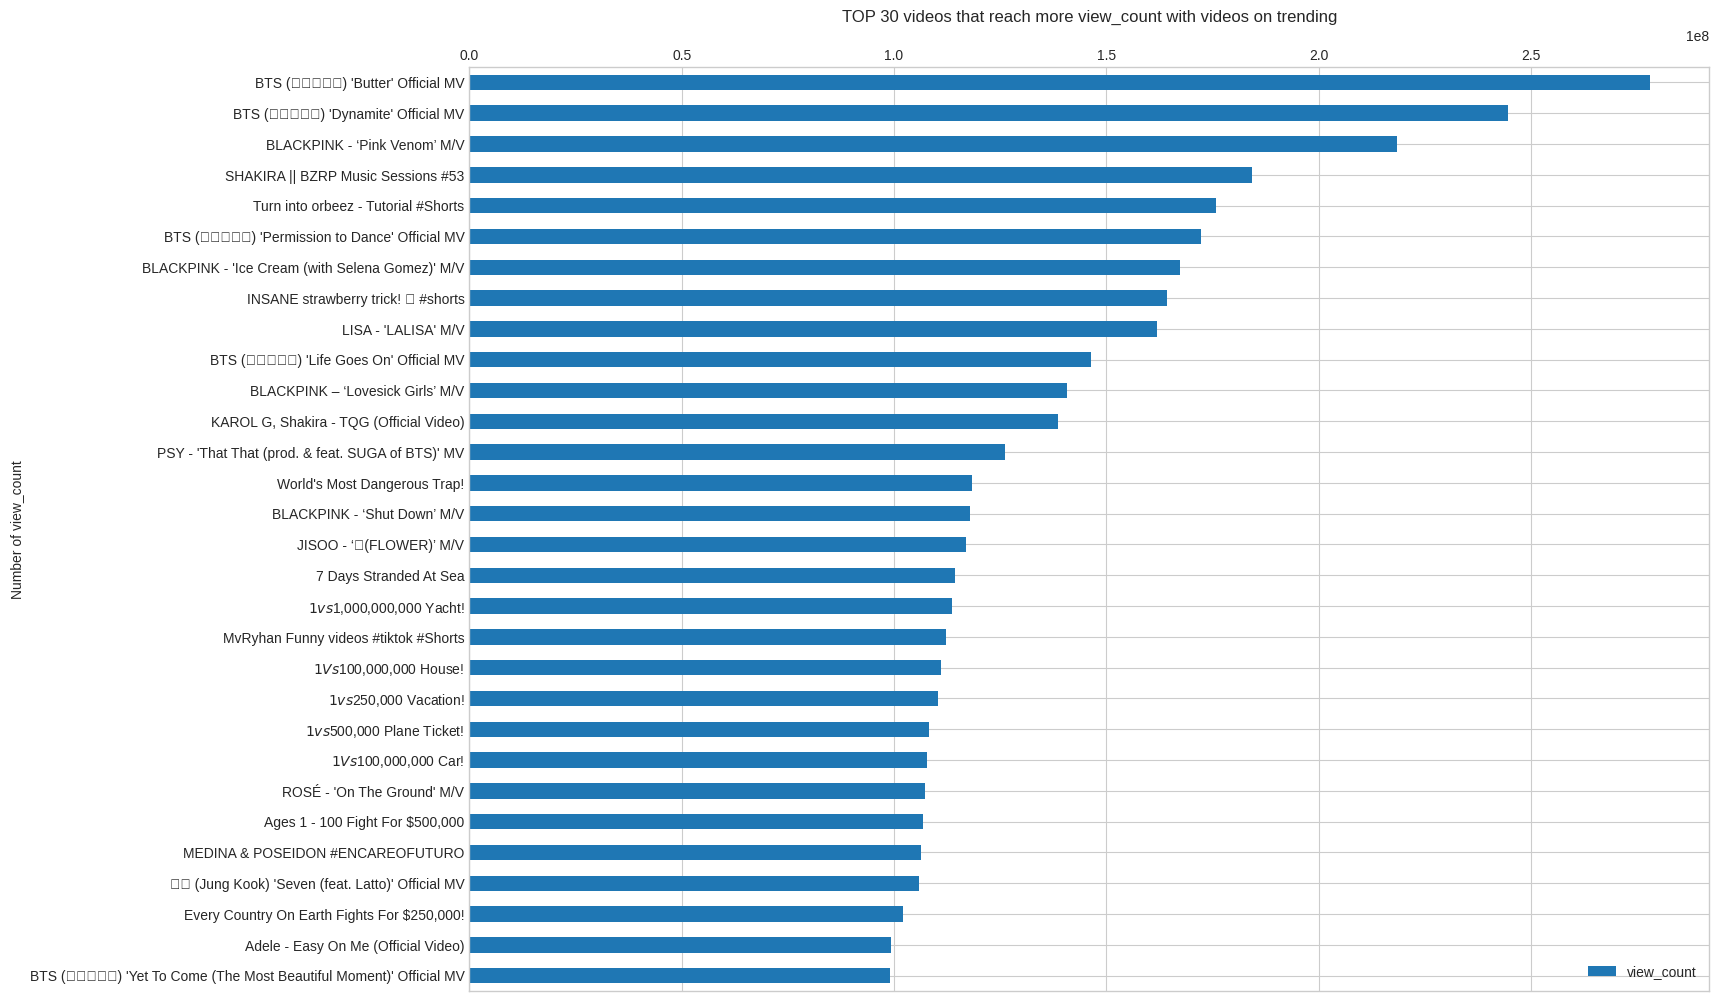

In [35]:
df_view_count = df_unique.select(["channelTitle", "video_id", "title", "view_count"])\
                         .orderBy(F.desc("view_count")).limit(config.num_of_videos_limit)
ax = df_view_count.toPandas().iloc[::-1].plot.barh(x="title",
                                  y="view_count",
                                  ylabel="Number of view_count",
                                  title=(f"TOP {config.num_of_videos_limit} videos that reach "
                                         f"more view_count with videos on trending"), 
                                  figsize=(16, 12))
ax.xaxis.tick_top()
df_view_count.show(3, truncate=False)

In [36]:
print((f"Channels with the most viewed videos on the trending "
       f"considering TOP {config.num_of_videos_limit}"))
df_view_count.groupby("channelTitle")\
             .count()\
             .alias("number_of_videos")\
             .orderBy(F.desc("count")).show()

Channels with the most viewed videos on the trending considering TOP 30
+--------------+-----+
|  channelTitle|count|
+--------------+-----+
|       MrBeast|    9|
|     BLACKPINK|    7|
|   HYBE LABELS|    4|
|Big Hit Labels|    2|
|      Bizarrap|    1|
|        FFUNTV|    1|
|    Dan Rhodes|    1|
|    KarolGVEVO|    1|
|   officialpsy|    1|
|      Mv Ryhan|    1|
|      bradesco|    1|
|     AdeleVEVO|    1|
+--------------+-----+



### likes

+--------------+-----------+--------------------------------------------------+--------+
|channelTitle  |video_id   |title                                             |likes   |
+--------------+-----------+--------------------------------------------------+--------+
|HYBE LABELS   |WMweEpGlu_U|BTS (방탄소년단) 'Butter' Official MV             |16213756|
|Big Hit Labels|gdZLi9oWNZg|BTS (방탄소년단) 'Dynamite' Official MV           |15948422|
|HYBE LABELS   |CuklIb9d3fI|BTS (방탄소년단) 'Permission to Dance' Official MV|12403586|
+--------------+-----------+--------------------------------------------------+--------+
only showing top 3 rows



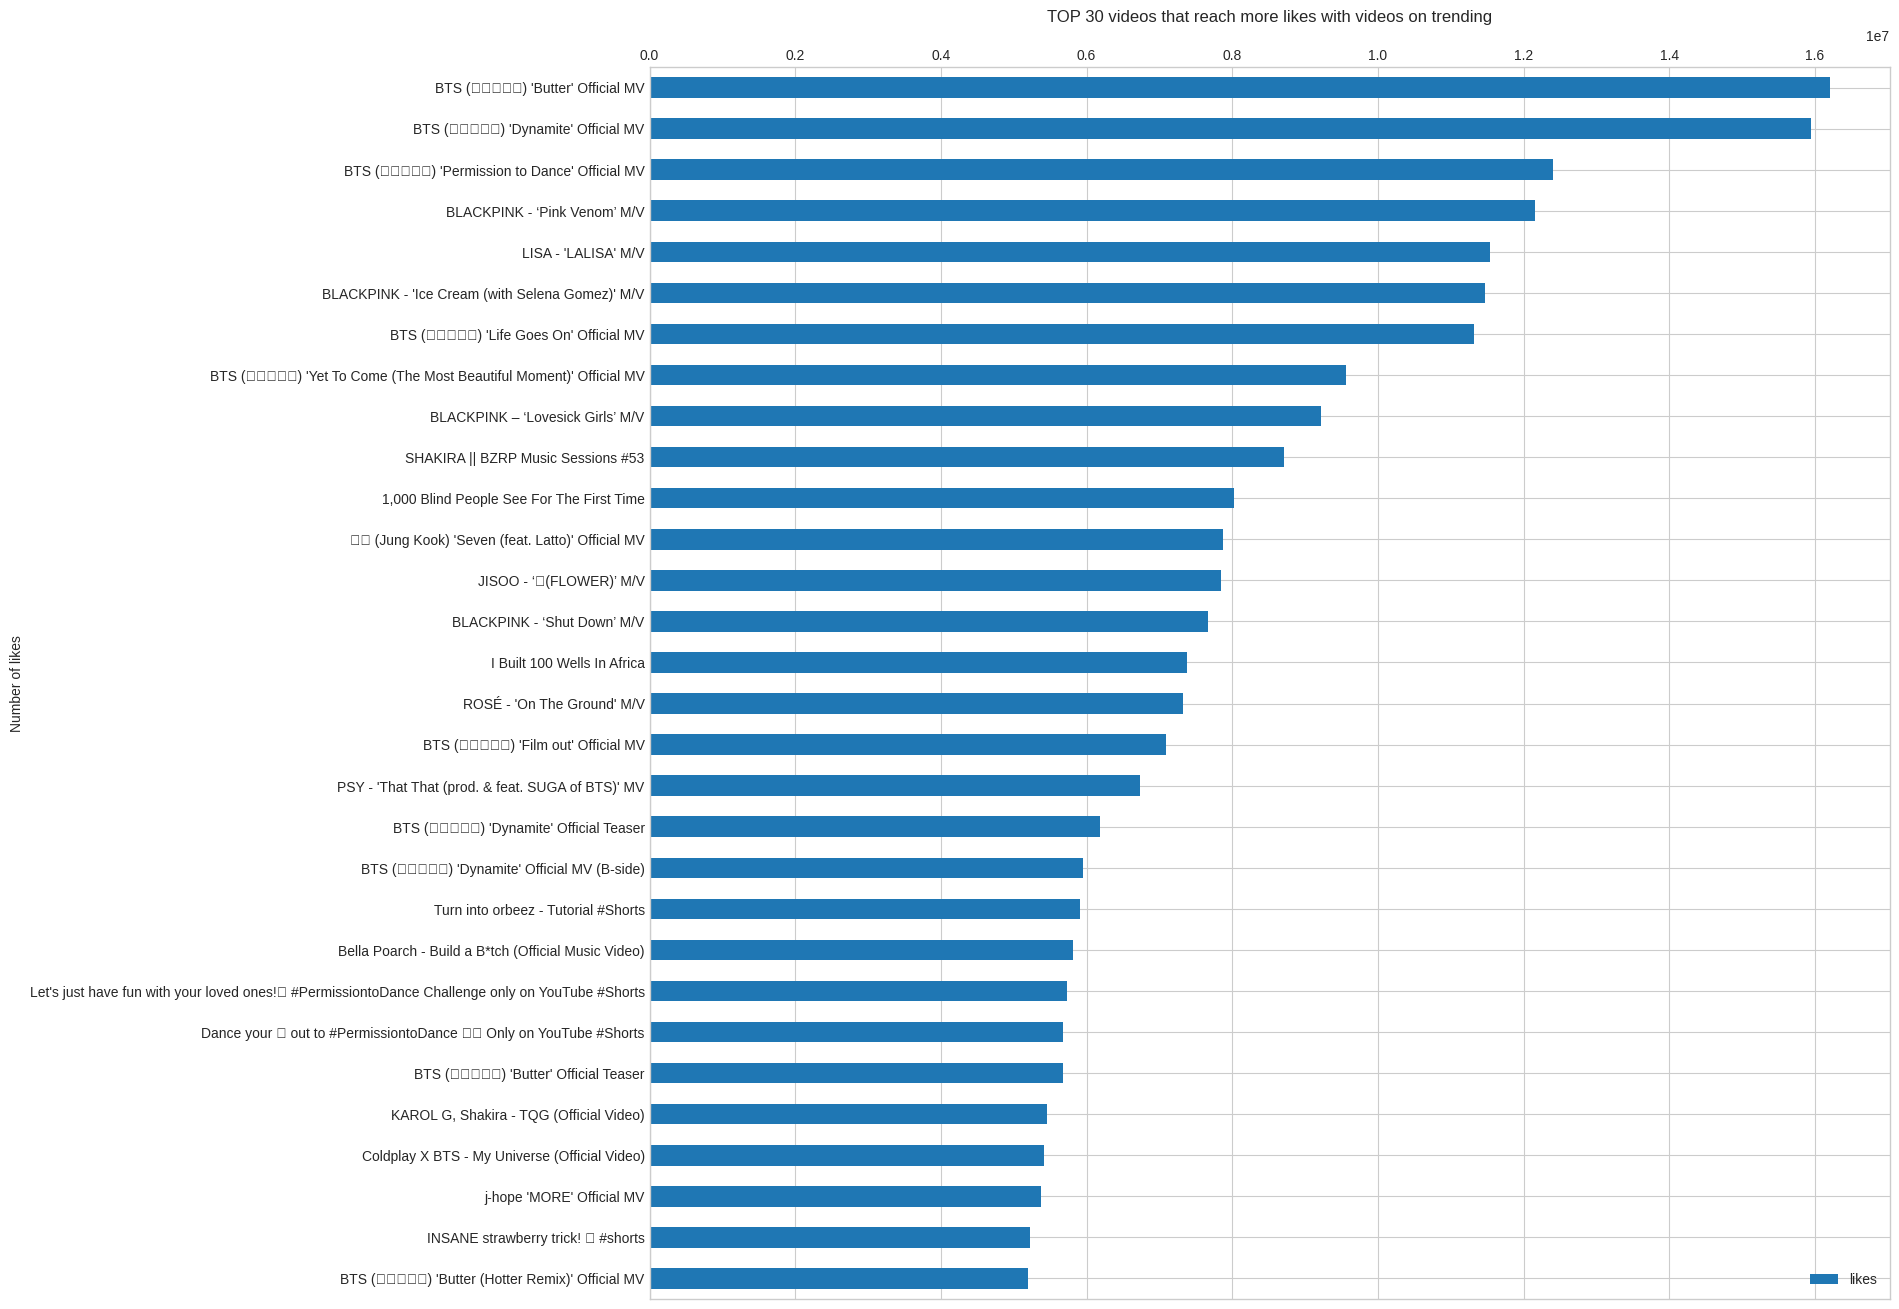

In [41]:
df_likes = df_unique.select(["channelTitle", "video_id", "title", "likes"])\
                         .orderBy(F.desc("likes")).limit(config.num_of_videos_limit)
ax = df_likes.toPandas().iloc[::-1].plot.barh(x="title",
                                         y="likes",
                                         ylabel="Number of likes",
                                         title=(f"TOP {config.num_of_videos_limit} videos that "
                                                 "reach more likes with videos on trending"), 
                                  figsize=(16, 16))
ax.xaxis.tick_top()
df_likes.show(3, truncate=False)

In [38]:
print(f"Channels with the most liked videos on the trending considering TOP {config.num_of_videos_limit}")
df_likes.groupby("channelTitle")\
             .count()\
             .alias("number_of_videos")\
             .orderBy(F.desc("count")).show()

Channels with the most liked videos on the trending considering TOP 30
+--------------+-----+
|  channelTitle|count|
+--------------+-----+
|   HYBE LABELS|    8|
|     BLACKPINK|    7|
|Big Hit Labels|    4|
|       MrBeast|    2|
|     BANGTANTV|    2|
|      Bizarrap|    1|
|   officialpsy|    1|
|        FFUNTV|    1|
|  Bella Poarch|    1|
|    KarolGVEVO|    1|
|      Coldplay|    1|
|    Dan Rhodes|    1|
+--------------+-----+



### dislikes

+--------------+-----------+--------------------------------------------------------------+--------+
|channelTitle  |video_id   |title                                                         |dislikes|
+--------------+-----------+--------------------------------------------------------------+--------+
|BLACKPINK     |vRXZj0DzXIA|BLACKPINK - 'Ice Cream (with Selena Gomez)' M/V               |848980  |
|Big Hit Labels|gdZLi9oWNZg|BTS (방탄소년단) 'Dynamite' Official MV                       |738814  |
|Cardi B       |hsm4poTWjMs|Cardi B - WAP feat. Megan Thee Stallion [Official Music Video]|408063  |
+--------------+-----------+--------------------------------------------------------------+--------+
only showing top 3 rows



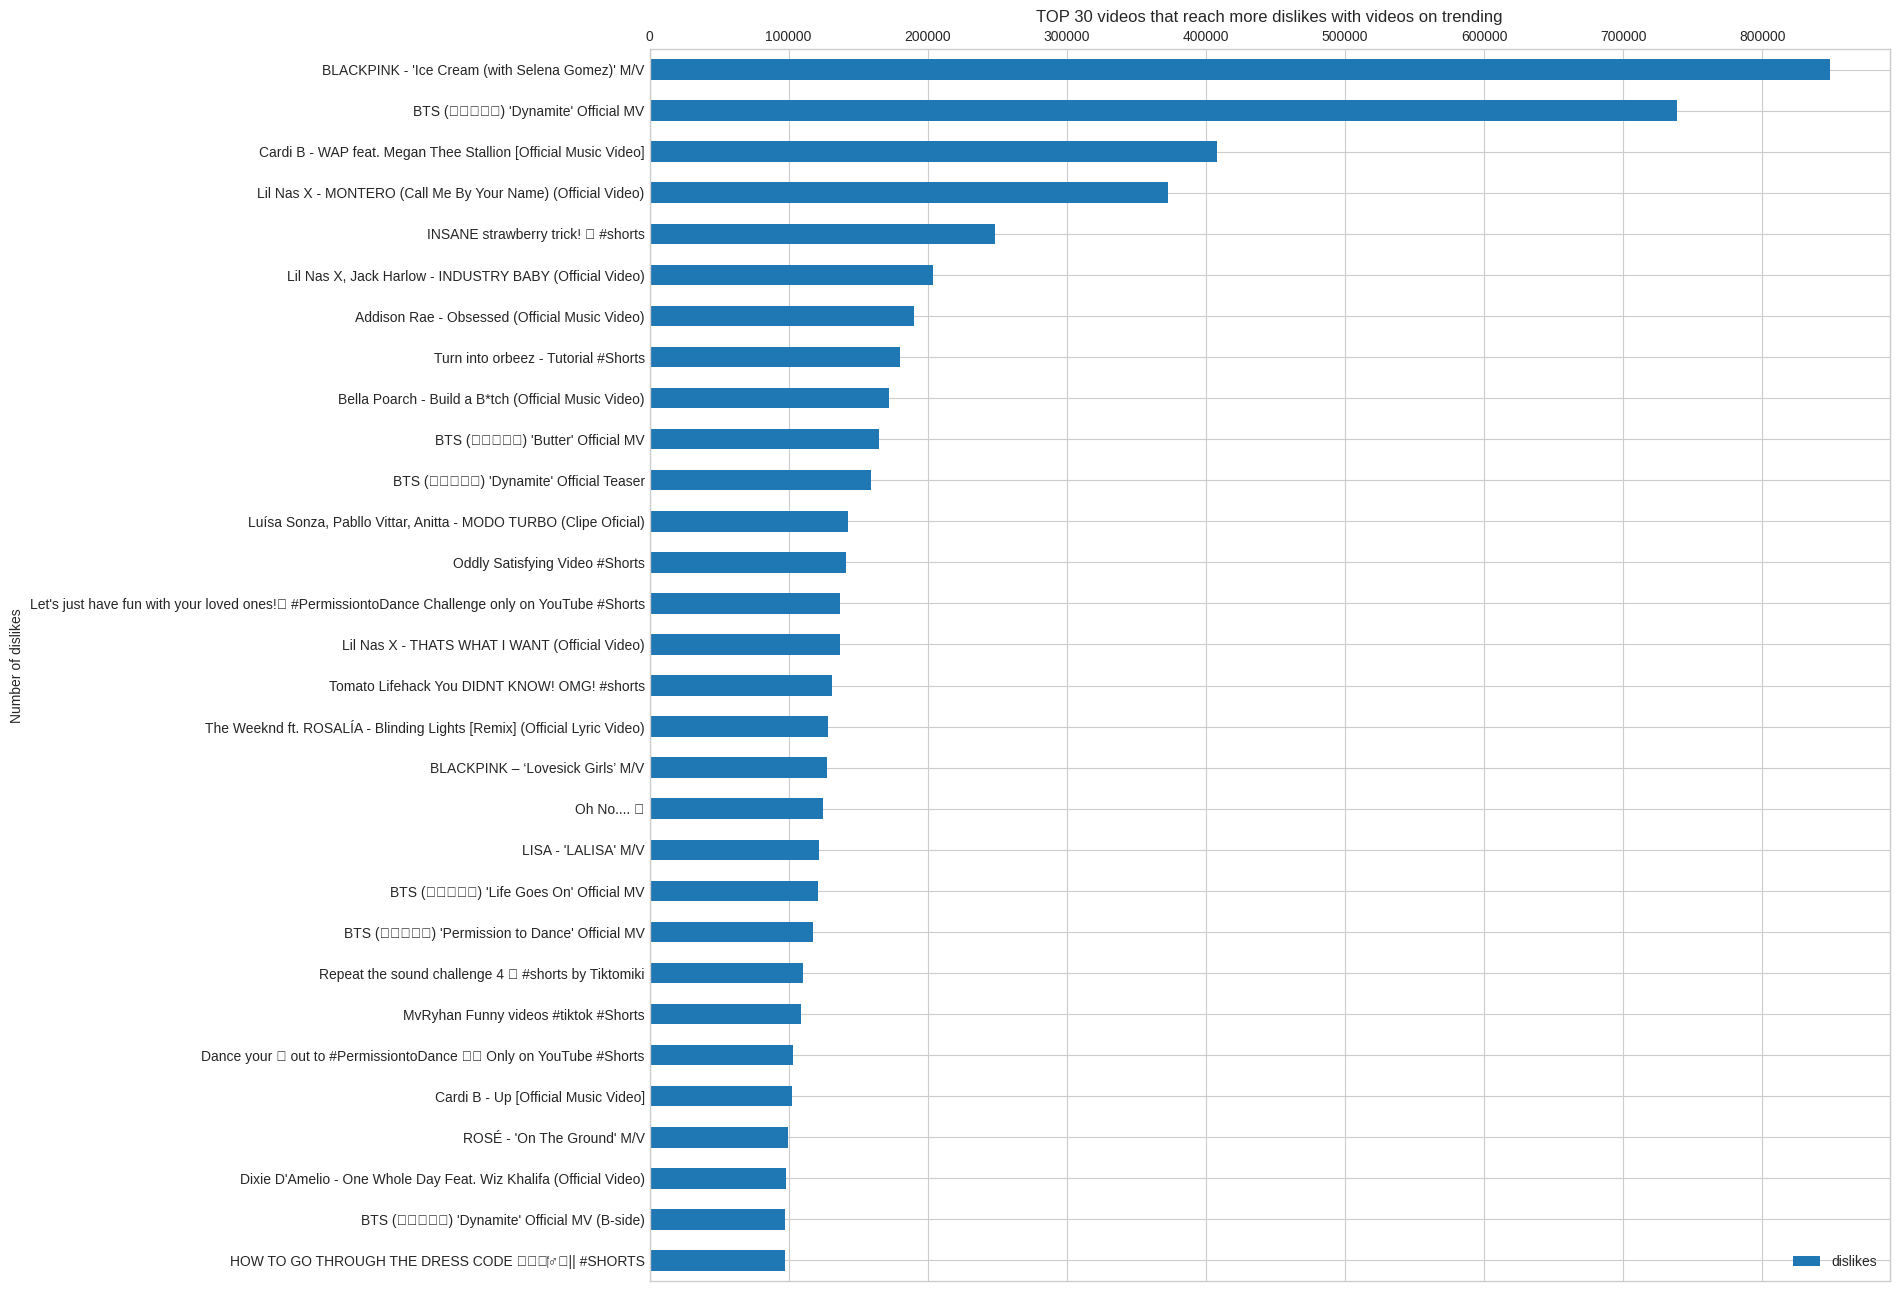

In [42]:
df_dislikes = df_unique.select(["channelTitle", "video_id", "title", "dislikes"])\
                         .orderBy(F.desc("dislikes")).limit(config.num_of_videos_limit)
ax = df_dislikes.toPandas().iloc[::-1].plot.barh(x="title",
                                            y="dislikes",
                                            ylabel="Number of dislikes",
                                            title=(f"TOP {config.num_of_videos_limit} videos that reach "
                                                    "more dislikes with videos on trending"), 
                                  figsize=(16, 16))
ax.xaxis.tick_top()
df_dislikes.show(3, truncate=False)

In [43]:
print(f"Channels with the most disliked videos on the trending considering TOP {config.num_of_videos_limit}")
df_dislikes.groupby("channelTitle")\
             .count()\
             .alias("number_of_videos")\
             .orderBy(F.desc("count")).show()

Channels with the most disliked videos on the trending considering TOP 30
+--------------------+-----+
|        channelTitle|count|
+--------------------+-----+
|           BLACKPINK|    4|
|      Big Hit Labels|    4|
|         LilNasXVEVO|    3|
|             Cardi B|    2|
|          Dan Rhodes|    2|
|         HYBE LABELS|    2|
|           BANGTANTV|    2|
|         Addison Rae|    1|
|              FFUNTV|    1|
|        Bella Poarch|    1|
|         Luísa Sonza|    1|
| Thanh Thảo Official|    1|
|            ZutiGang|    1|
|       TheWeekndVEVO|    1|
|           TIKTOMIKI|    1|
|            Mv Ryhan|    1|
|      Dixie D'Amelio|    1|
|5-Minute Crafts F...|    1|
+--------------------+-----+



## Most commented videos

+--------------+-----------+-------------------------------------------+-------------+
|channelTitle  |video_id   |title                                      |comment_count|
+--------------+-----------+-------------------------------------------+-------------+
|HYBE LABELS   |WMweEpGlu_U|BTS (방탄소년단) 'Butter' Official MV      |6817450      |
|Big Hit Labels|gdZLi9oWNZg|BTS (방탄소년단) 'Dynamite' Official MV    |6188815      |
|Big Hit Labels|-5q5mZbe3V8|BTS (방탄소년단) 'Life Goes On' Official MV|4137072      |
+--------------+-----------+-------------------------------------------+-------------+
only showing top 3 rows



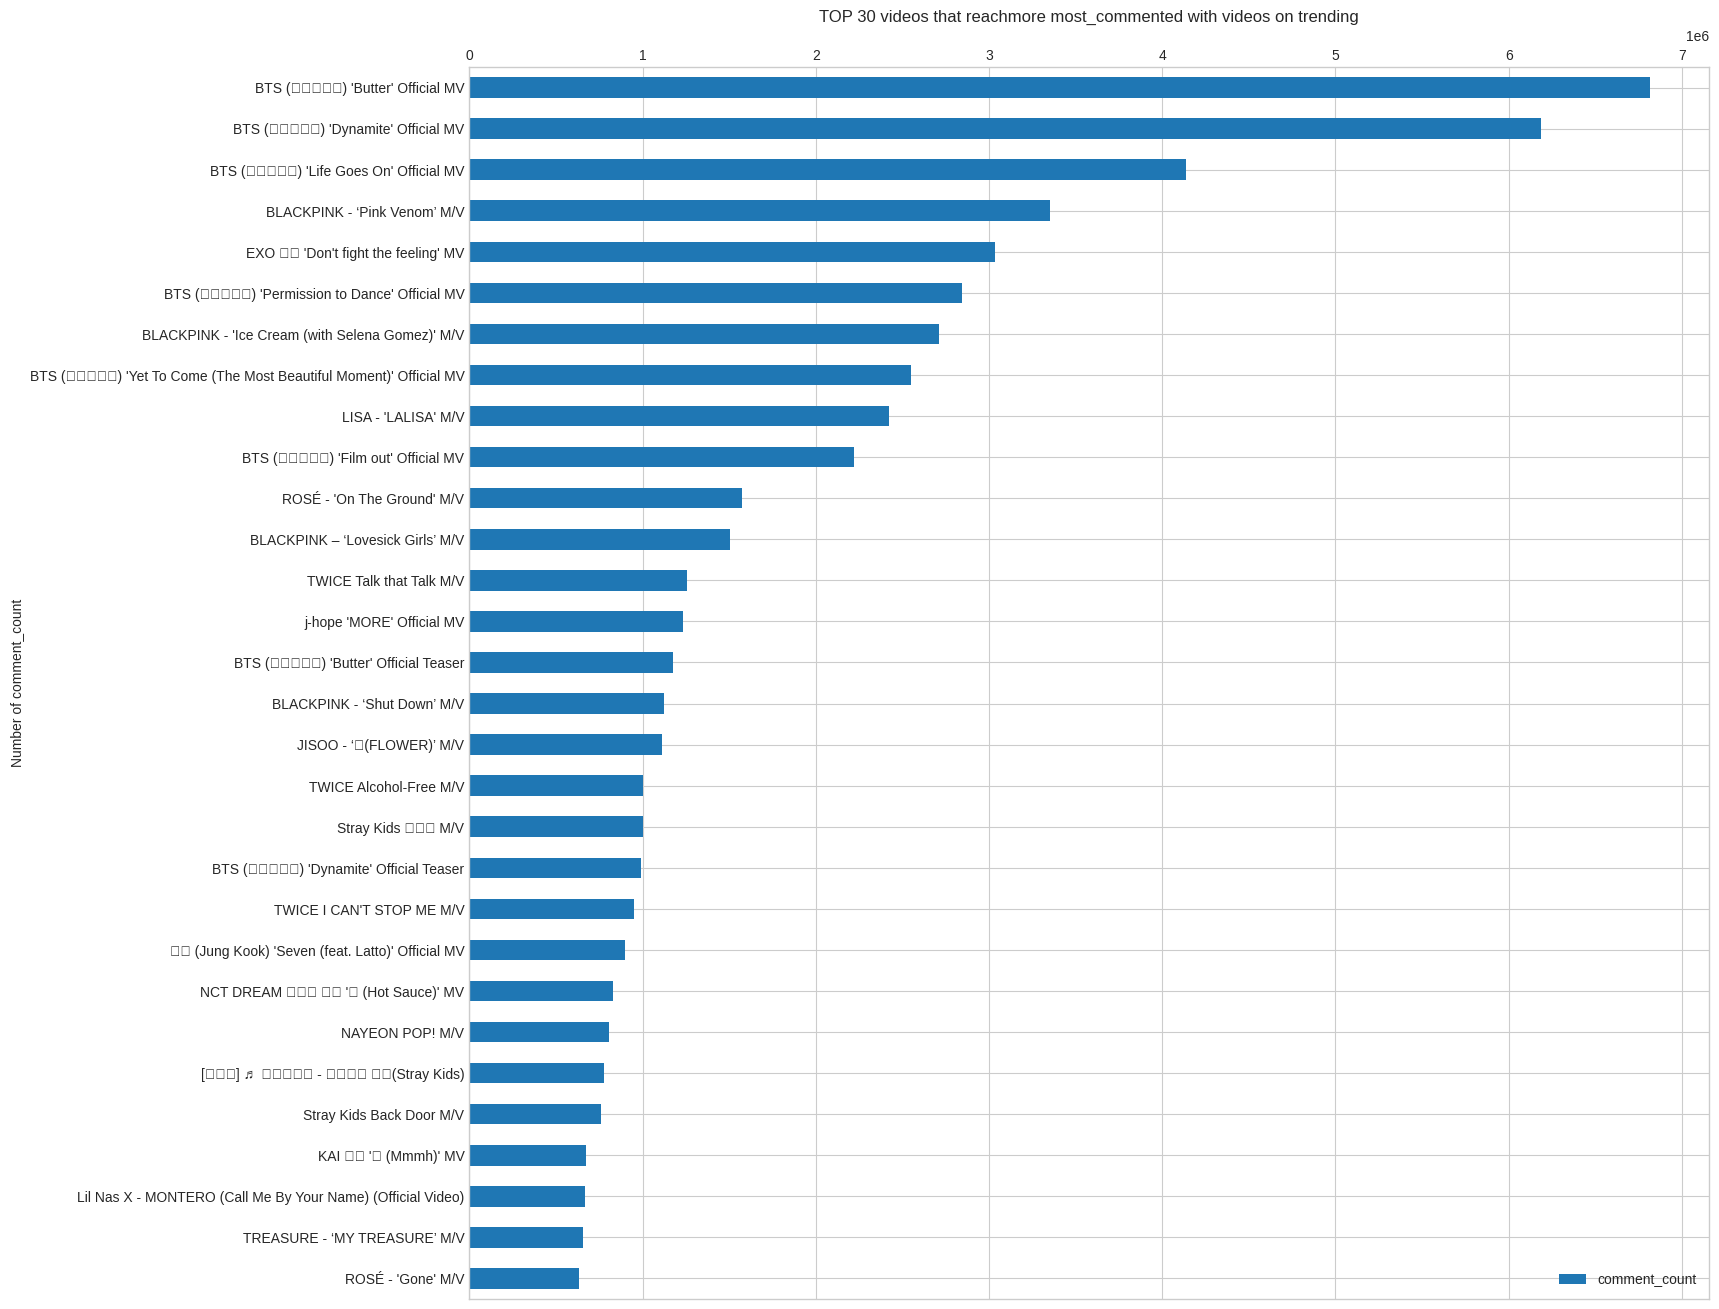

In [44]:
df_comment_count = df_unique.select(["channelTitle", "video_id", "title", "comment_count"])\
                         .orderBy(F.desc("comment_count")).limit(config.num_of_videos_limit)
ax = df_comment_count.toPandas().iloc[::-1].plot.barh(x="title",
                                                 y="comment_count",
                                                 ylabel="Number of comment_count",
                                                 title=(f"TOP {config.num_of_videos_limit} videos that reach"
                                                         "more most_commented with videos on trending"), 
                                                         figsize=(16, 16))
ax.xaxis.tick_top()
df_comment_count.show(3, truncate=False)

## Tags of the videos that reach the YouTube Trending

In [45]:
df_tags = df_unique.withColumn("tags_splitted", F.split(F.col("tags"), pattern="[|]"))\
                          .select(["channelId", "channelTitle", "video_id", "title", "tags_splitted"])
print(f"Number of tags: {df_tags.count()}")

Number of tags: 36109


In [46]:
df_tags_exploded = df_tags.select(F.explode("tags_splitted").alias("tags"))
df_tags_exploded = df_tags_exploded.withColumn("tags", F.lower("tags"))
df_tags_exploded = df_tags_exploded.groupby("tags").count().orderBy(F.desc("count"))
df_tags_exploded.show(20)

+-----------------+-----+
|             tags|count|
+-----------------+-----+
|           [none]| 5421|
|          futebol| 2540|
|        minecraft| 1844|
|melhores momentos| 1680|
|             gols| 1638|
|         flamengo| 1178|
|              gol| 1174|
|            humor| 1126|
|          ao vivo| 1115|
|          esporte| 1052|
|            globo| 1040|
|    globo esporte| 1008|
|             vlog|  998|
|      brasileirão|  950|
|           brasil|  923|
|         esportes|  882|
|        engraçado|  871|
|           sportv|  862|
|               ge|  853|
|         ge.globo|  818|
+-----------------+-----+
only showing top 20 rows



**Analysis:** The interesting part here is that many videos that goes to trending don't have tags 😵

## Comments and Ratings

In [47]:
df_comments_disabled = df_unique.groupBy("comments_disabled")\
                               .count()\
                               .where(F.col("comments_disabled")\
                               .isin([False, True]))
df_ratings_disabled = df_unique.groupBy("ratings_disabled")\
                               .count()\
                               .where(F.col("ratings_disabled")\
                               .isin([False, True]))
df_comments_disabled = df_comments_disabled.withColumn("percentage (%)", F.col("count") / df_comments_disabled.agg(F.sum("count")).first()[0] * 100 )
df_ratings_disabled = df_ratings_disabled.withColumn("percentage (%)", F.col("count") / df_ratings_disabled.agg(F.sum("count")).first()[0] * 100 )

In [48]:
for row in df_ratings_disabled.select("ratings_disabled", "percentage (%)").collect():
    print(f"Ratings disabled ({row['ratings_disabled']}) = {row['percentage (%)']:.2f}%")

Ratings disabled (True) = 0.75%
Ratings disabled (False) = 99.25%


In [49]:
for row in df_comments_disabled.select("comments_disabled", "percentage (%)").collect():
    print(f"comments disabled ({row['comments_disabled']}) = {row['percentage (%)']:.2f}%")

comments disabled (True) = 1.76%
comments disabled (False) = 98.24%


In general, the videos that go to the YouTube Trending have the comments and ratings enabled ✅!

## Correlation Analysis

In [50]:
features = ["view_count", "likes", "dislikes", "comment_count"]
vecAssembler = VectorAssembler(inputCols=features,
                               outputCol="output", 
                               handleInvalid="skip")

In [51]:
df_corr = vecAssembler.transform(df_unique).select("output")
df_corr.show(3, truncate=False)
corr = Correlation.corr(df_corr, "output").collect()[0][0].toArray()

+-----------------------------+
|output                       |
+-----------------------------+
|[906416.0,38531.0,0.0,4166.0]|
|[130394.0,15011.0,0.0,301.0] |
|[335838.0,21740.0,0.0,1063.0]|
+-----------------------------+
only showing top 3 rows



23/11/20 21:59:03 WARN InstanceBuilder: Failed to load implementation from:dev.ludovic.netlib.blas.VectorBLAS


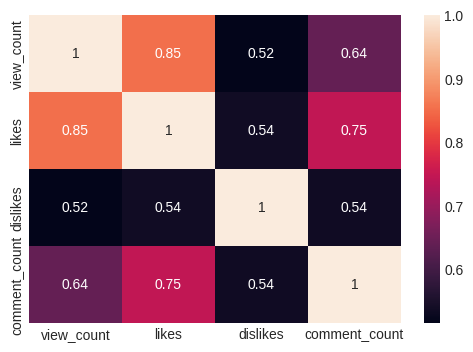

In [52]:
plt.figure(figsize=(6, 4))
sns.heatmap(corr, annot=True, xticklabels=features, yticklabels=features)
plt.show()

**Analysis:** the quantity of views has lower correlation with dislikes 👎. Has good correlation with the number of likes 👍

## Trending Date

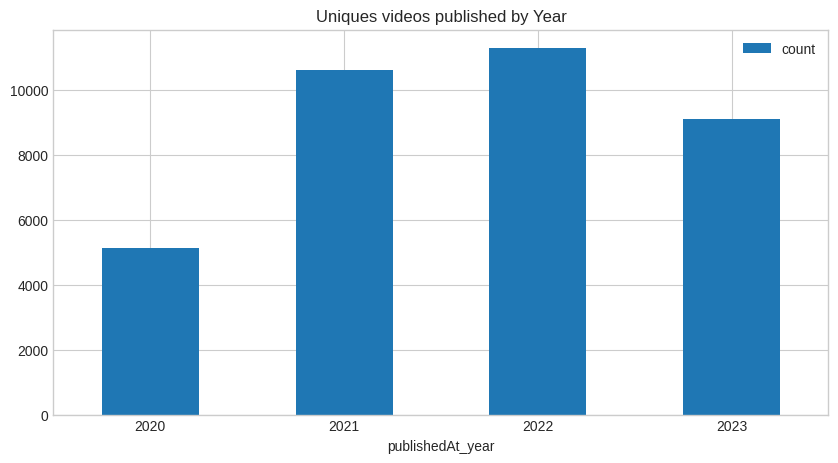

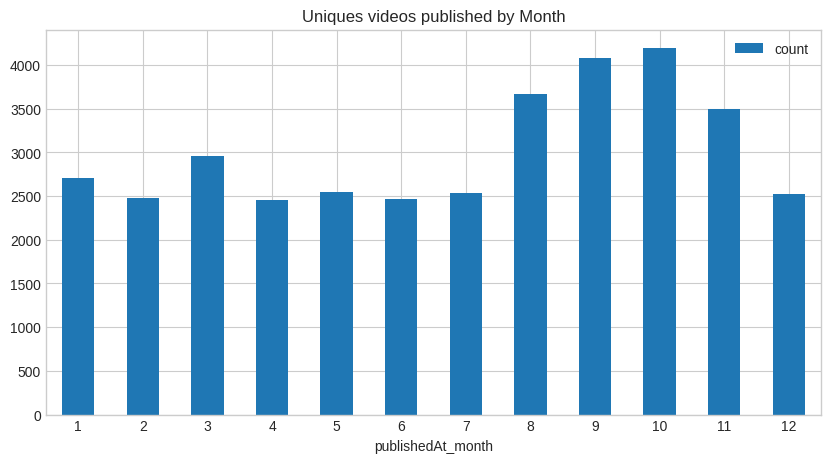

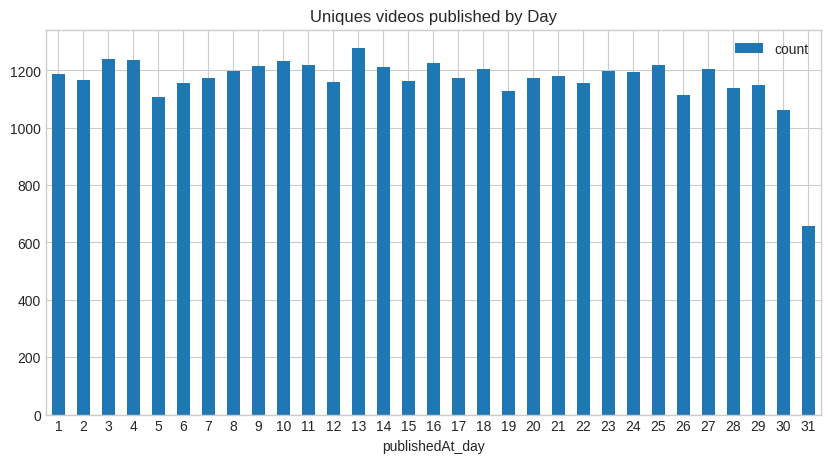

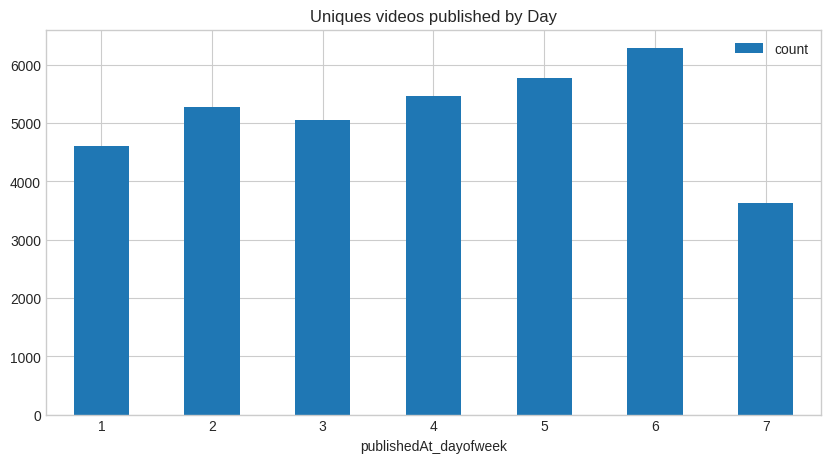

In [53]:
df_date = df_unique.withColumn("publishedAt_year", F.year(F.col("publishedAt")))
df_date = df_date.withColumn("publishedAt_month", F.month(F.col("publishedAt")))
df_date = df_date.withColumn("publishedAt_day", F.day(F.col("publishedAt")))
df_date = df_date.withColumn("publishedAt_dayofweek", F.dayofweek(F.col("publishedAt")))
ax = df_date.groupby("publishedAt_year").count().orderBy(F.col("publishedAt_year"))\
                                   .toPandas().plot.bar(x="publishedAt_year", 
                                                        y="count", 
                                                        title="Uniques videos published by Year", 
                                                        figsize=(10, 5))
ax.tick_params(axis="x", rotation=0)
ax = df_date.groupby("publishedAt_month").count().orderBy(F.col("publishedAt_month"))\
                                   .toPandas().plot.bar(x="publishedAt_month", 
                                                        y="count", 
                                                        title="Uniques videos published by Month", 
                                                        figsize=(10, 5))
ax.tick_params(axis="x", rotation=0)
ax = df_date.groupby("publishedAt_day").count().orderBy(F.col("publishedAt_day"))\
                                   .toPandas().plot.bar(x="publishedAt_day", 
                                                        y="count", 
                                                        title="Uniques videos published by Day", 
                                                        figsize=(10, 5))
ax.tick_params(axis="x", rotation=0)
ax = df_date.groupby("publishedAt_dayofweek").count().orderBy(F.col("publishedAt_dayofweek"))\
                                   .toPandas().plot.bar(x="publishedAt_dayofweek", 
                                                        y="count", 
                                                        title="Uniques videos published by Day", 
                                                        figsize=(10, 5))
ax.tick_params(axis="x", rotation=0)

**Analysis 1:** The months after August have more unique videos on trending (We don't reach December 2023 and for that reason, the bar is small)

**Analysis 2:** The day of the month doesn't matter, it is almost uniform

**Analysis 3:** "Ranges from 1 for a Sunday through to 7 for a Saturday", which means that the best day of week to upload the video is Friday and the worst is Saturday. This can be explained by the fact that on Saturday, a considerable quantity of users go out 🎉

## Time to enter on YouTube Trending

In [54]:
df_trending_date = df_unique.select(["title", "publishedAt", "trending_date"])
df_trending_date = df_trending_date.withColumn("diff", 
                                               F.datediff(F.col("trending_date"), 
                                                          F.col("publishedAt")))
df_trending_date.show(3, truncate=False)

+------------------------------------------------------------------+-------------------+-------------------+----+
|title                                                             |publishedAt        |trending_date      |diff|
+------------------------------------------------------------------+-------------------+-------------------+----+
|ARMADILHA DE GOLENS PARA PROTEGER CASA DO MINECRAFT               |2022-03-24 10:30:00|2022-03-29 21:00:00|5   |
|ESTOU MUITO FELIZ QUE O MEU IRMÃO DEU UM BEIJO NA DANI!!!!! *danan|2022-07-04 19:38:17|2022-07-12 21:00:00|8   |
|Mamonas Assassinas - O Filme | Trailer Oficial                    |2023-10-31 12:06:20|2023-11-08 21:00:00|8   |
+------------------------------------------------------------------+-------------------+-------------------+----+
only showing top 3 rows



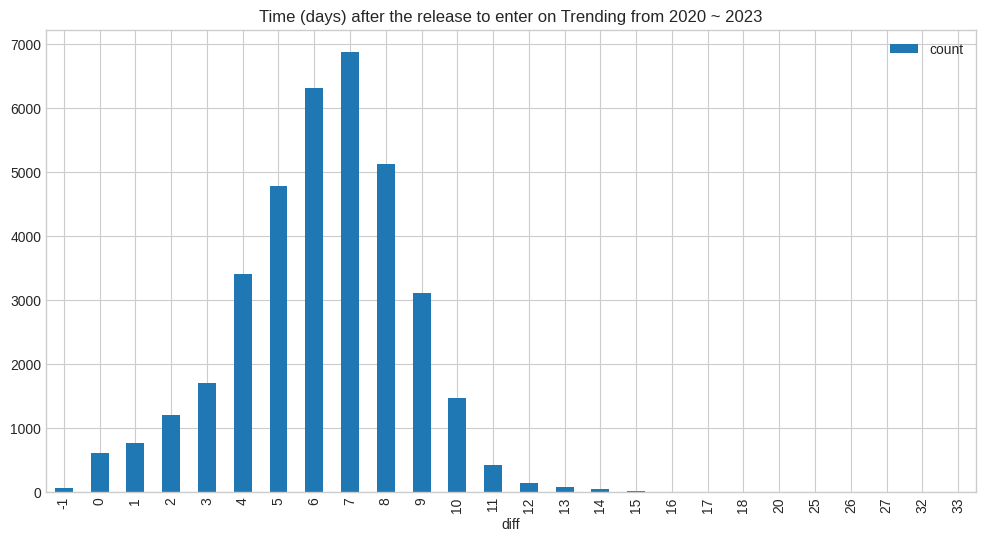

In [56]:
df_trending_date.groupBy("diff").count()\
                .orderBy(F.col("diff"))\
                .toPandas()\
                .plot.bar(x="diff", 
             y="count",
             title=f"Time (days) after the release to enter on Trending from {years[0].split('-')[0]} ~ {years[-1].split('-')[0]}",
             figsize=(12, 6))
plt.show()

### Checking the last year

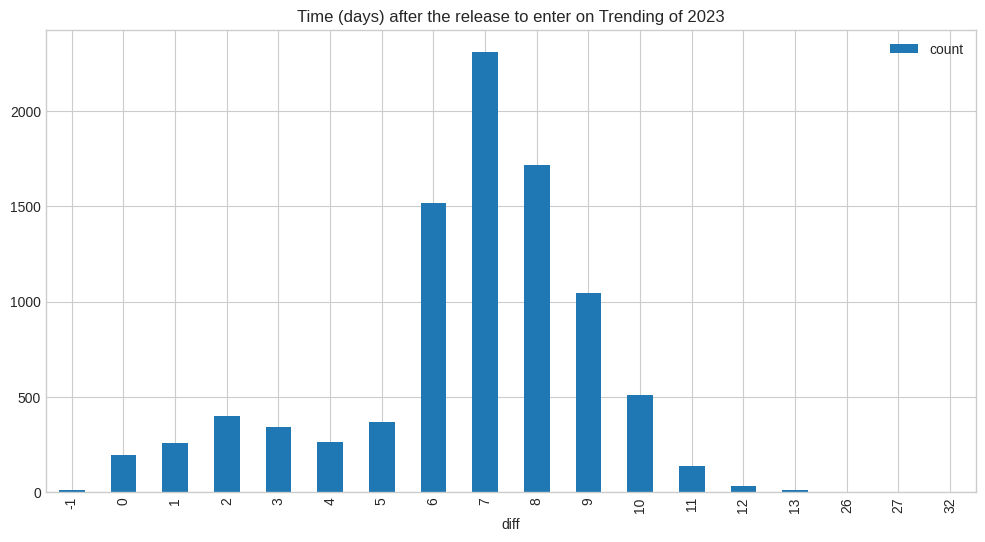

In [58]:
df_trending_date_2023 = df_unique.select(["title", "publishedAt", "trending_date"]).filter(F.col("publishedAt") >= F.lit(years[-1]))
df_trending_date_2023 = df_trending_date_2023.withColumn("diff", F.datediff(F.col("trending_date"), F.col("publishedAt")))
df_trending_date_2023.groupBy("diff")\
                     .count().orderBy(F.col("diff"))\
                     .toPandas().plot.bar(x="diff", 
                     y="count",
                     title=f"Time (days) after the release to enter on Trending of {years[-1].split('-')[0]}",
                     figsize=(12, 6))
plt.show()

## Trending hour of the day

In [59]:
df_trending_hour = df_unique.select(["publishedAt"]).filter(F.col("publishedAt") >= F.lit(years[-1]))

In [61]:
df_trending_hour = df_trending_hour.withColumn("publishedAt_hour", F.hour(F.col("publishedAt")))\
                                   .withColumn("publishedAt_dow", F.dayofweek(F.col("publishedAt")))
df_trending_hour.show(3, truncate=False)

+-------------------+----------------+---------------+
|publishedAt        |publishedAt_hour|publishedAt_dow|
+-------------------+----------------+---------------+
|2023-10-31 12:06:20|12              |3              |
|2023-06-27 20:00:00|20              |3              |
|2023-06-04 21:30:55|21              |1              |
+-------------------+----------------+---------------+
only showing top 3 rows



### Sunday

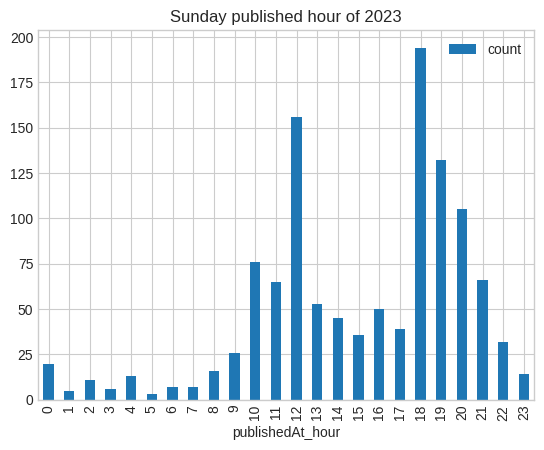

In [62]:
df_trending_hour.filter((F.col("publishedAt_dow") == 1))\
                .groupBy("publishedAt_hour").count().orderBy(F.col("publishedAt_hour"))\
                .toPandas().plot.bar(x="publishedAt_hour", y="count",
                                     title=f"Sunday published hour of {years[-1].split('-')[0]}")
plt.show()

### Monday

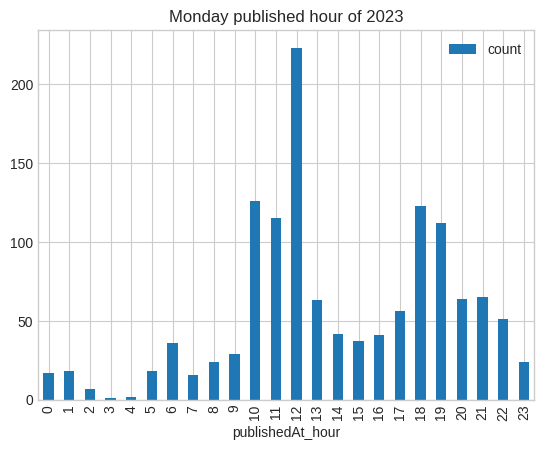

In [63]:
df_trending_hour.filter(F.col("publishedAt_dow") == 2)\
                .groupBy("publishedAt_hour").count().orderBy(F.col("publishedAt_hour"))\
                .toPandas().plot.bar(x="publishedAt_hour", y="count",
                                     title=f"Monday published hour of {years[-1].split('-')[0]}")
plt.show()

### Tuesday

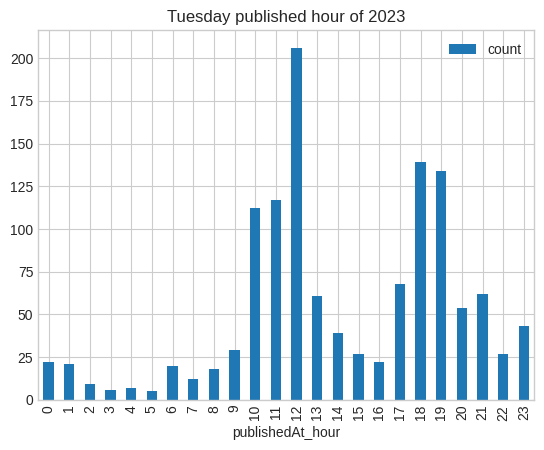

In [64]:
df_trending_hour.filter(F.col("publishedAt_dow") == 3)\
                .groupBy("publishedAt_hour").count().orderBy(F.col("publishedAt_hour"))\
                .toPandas().plot.bar(x="publishedAt_hour", y="count",
                                     title=f"Tuesday published hour of {years[-1].split('-')[0]}")
plt.show()

### Wednesday

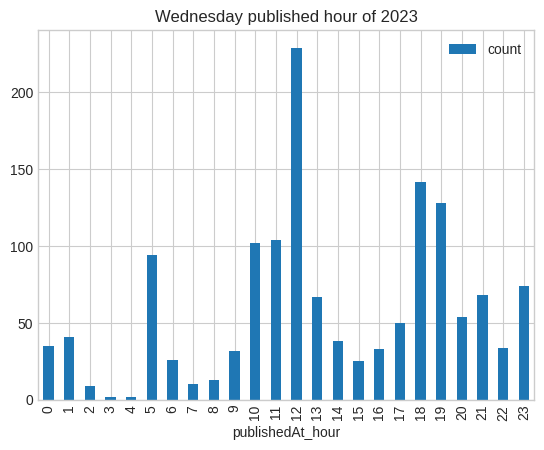

In [65]:
df_trending_hour.filter(F.col("publishedAt_dow") == 4)\
                .groupBy("publishedAt_hour").count().orderBy(F.col("publishedAt_hour"))\
                .toPandas().plot.bar(x="publishedAt_hour", y="count",
                                     title=f"Wednesday published hour of {years[-1].split('-')[0]}")
plt.show()

### Thursday

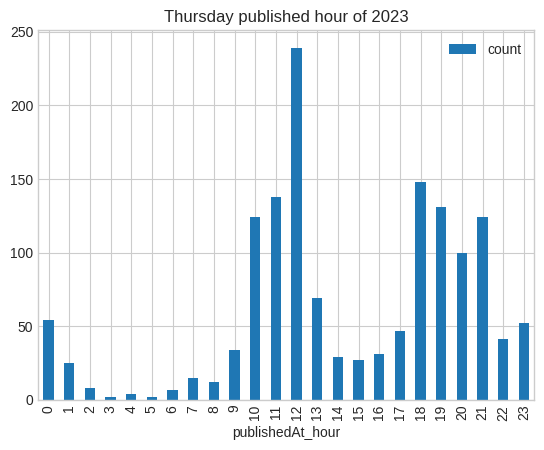

In [66]:
df_trending_hour.filter(F.col("publishedAt_dow") == 5)\
                .groupBy("publishedAt_hour").count().orderBy(F.col("publishedAt_hour"))\
                .toPandas().plot.bar(x="publishedAt_hour", y="count",
                                     title=f"Thursday published hour of {years[-1].split('-')[0]}")
plt.show()

### Friday

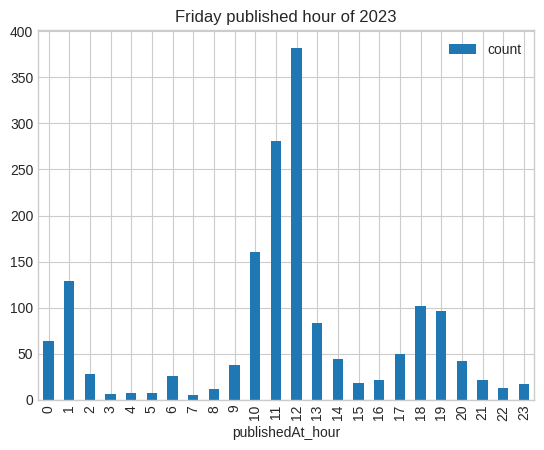

In [67]:
df_trending_hour.filter(F.col("publishedAt_dow") == 6)\
                .groupBy("publishedAt_hour").count().orderBy(F.col("publishedAt_hour"))\
                .toPandas().plot.bar(x="publishedAt_hour", y="count",
                                     title=f"Friday published hour of {years[-1].split('-')[0]}")
plt.show()

### Saturday

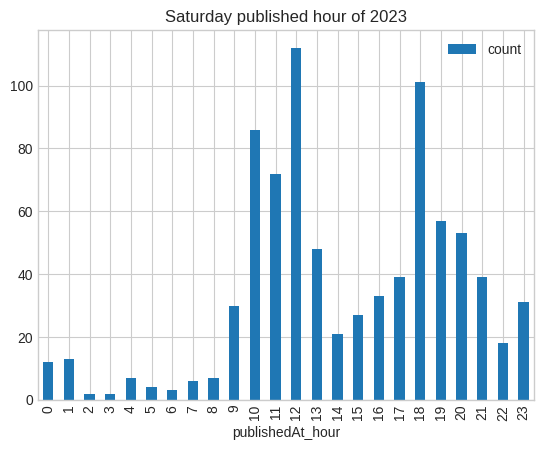

In [68]:
df_trending_hour.filter(F.col("publishedAt_dow") == 7)\
                .groupBy("publishedAt_hour").count().orderBy(F.col("publishedAt_hour"))\
                .toPandas().plot.bar(x="publishedAt_hour", y="count",
                                     title=f"Saturday published hour of {years[-1].split('-')[0]}")
plt.show()

**Analysis:** The best hour to publish the video is 12:00 PM ☀️, but 18:00 PM is good too 🌄 (Saturday or Sunday)

## Title Analysis

+----------------------------------------------+-------------------------------------------+
|title                                         |title_tokenize                             |
+----------------------------------------------+-------------------------------------------+
|LEVEI UM FORA? FINGI ESTAR APAIXONADO POR ELA!|[levei, fora, ?, fingi, apaixonado, ela, !]|
|ITZY “Not Shy” M/V TEASER                     |[itzy, not, shy, teaser]                   |
|Oh Juliana PARÓDIA - MC Niack                 |[oh, juliana, paródia, mc, niack]          |
+----------------------------------------------+-------------------------------------------+
only showing top 3 rows



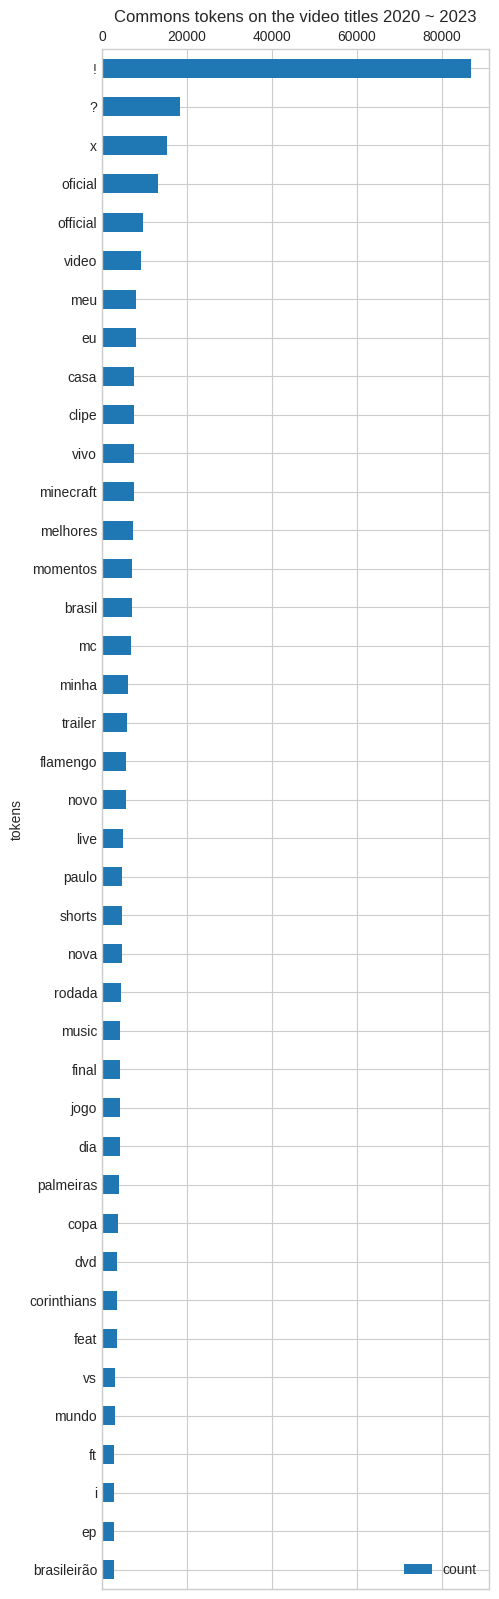

In [76]:
title_tokenize_udf = F.udf(lambda title: title_tokenize(title), ArrayType(StringType()))
df_title_tokenize = df.withColumn("title_tokenize", title_tokenize_udf(F.col("title")))\
                      .select("title", "title_tokenize")
df_title_tokenize.show(3, truncate=False)
df_title_tokens = df_title_tokenize.select(F.explode("title_tokenize").alias("tokens"))
df_title_tokens = df_title_tokens.groupBy("tokens").count()\
                                 .orderBy(F.desc(F.col("count"))).limit(40)
ax = df_title_tokens.toPandas()\
               .iloc[::-1].plot.barh(x="tokens", 
                            y="count", 
                            figsize=(5, 20),
                            title=f"Commons tokens on the video titles {years[0].split('-')[0]} ~ {years[-1].split('-')[0]}")
ax.xaxis.tick_top()
plt.show()

+--------------------------------------------------------------------+---------------------------------------------------------------------------+
|title                                                               |title_tokenize                                                             |
+--------------------------------------------------------------------+---------------------------------------------------------------------------+
|GOT the beat 'Stamp On It' Stage Video                              |[got, beat, on, it, stage, video]                                          |
|Yield To Warrior Champion's Shield! Clash of Clans Season Challenges|[yield, to, warrior, champion, shield, !, clash, clans, season, challenges]|
|107 FATOS do Minecraft Que Você Queria Saber Antes                  |[fatos, minecraft, queria, saber, antes]                                   |
+--------------------------------------------------------------------+------------------------------------------------

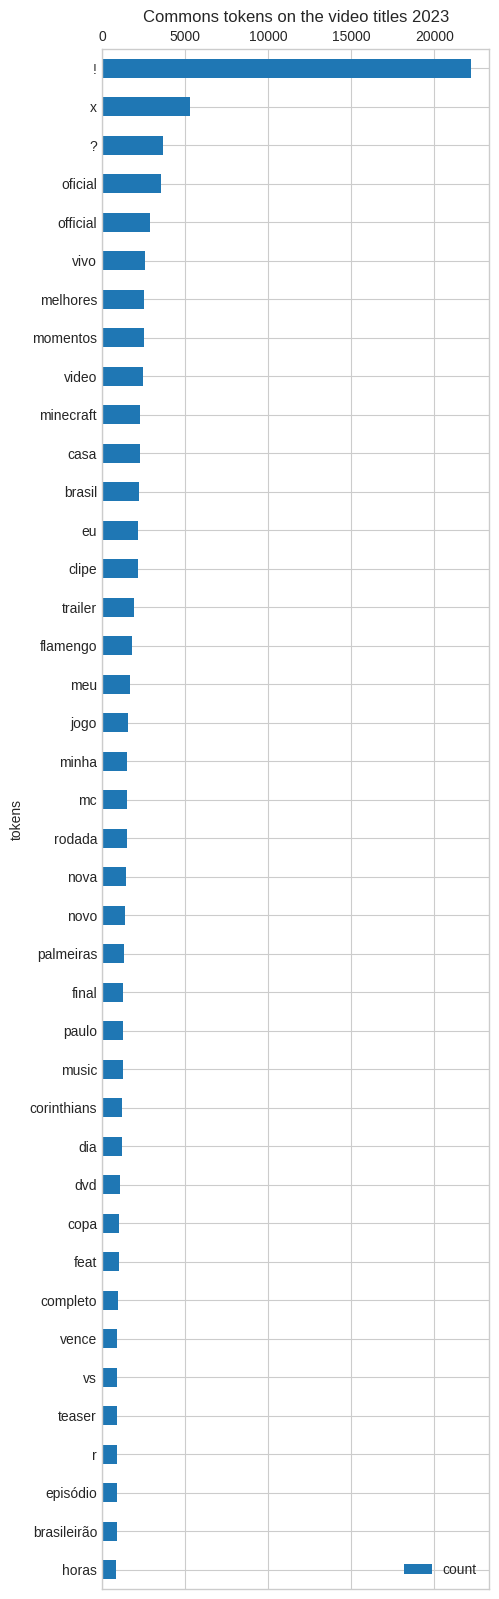

In [77]:
title_tokenize_udf = F.udf(lambda title: title_tokenize(title), ArrayType(StringType()))
df_title_tokenize = df.filter(F.col("publishedAt") >= F.lit(years[-1]))\
                      .withColumn("title_tokenize", title_tokenize_udf(F.col("title")))\
                      .select("title", "title_tokenize")
df_title_tokenize.show(3, truncate=False)
df_title_tokens = df_title_tokenize.select(F.explode("title_tokenize").alias("tokens"))
df_title_tokens = df_title_tokens.groupBy("tokens").count()\
                                 .orderBy(F.desc(F.col("count"))).limit(40)
ax = df_title_tokens.toPandas().iloc[::-1].plot.barh(x="tokens", 
                                                y="count", 
                                                figsize=(5, 20),
                                                title=f"Commons tokens on the video titles {years[-1].split('-')[0]}")
ax.xaxis.tick_top()
plt.show()

# End Notes

There are a huge other analysis to create on top of the dataset! It was fun to work with PySpark 🚀 instead of Pandas 🐼! 

---

This Jupyter Notebook was created by **BrenoAV**. For any inquiries or feedback, please feel free to create an issue on [GitHub](https://github.com/BrenoAV/Youtube-Trending-Video-Analysis/issues) 📣.